In [ ]:
# pip install git+https://github.com/qiskit-community/qaoa_training_pipeline

In [9]:
from qaoa_training_pipeline.evaluation import MPSEvaluator
from qaoa_training_pipeline.utils.graph_utils import load_graph, graph_to_operator
import time
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def energy_fun(sol, graph):
    spin = {"0":-1, "1":+1}
    energy = 0
    for i , j in graph.edges():
        energy += graph[i][j]["weight"] * (1 - spin[sol[i]] * spin[sol[j]]) / 2 
    return energy

In [27]:
nq = 60
graph_type = "1D"
backend_name = "qasm_simulator"
data = np.load(f"{nq}_{graph_type}.npy", allow_pickle=True).item()
graph = data["G"]
max_weight = max([data["G"][i][j]["weight"] for i, j in data["G"].edges()])

# QAOA training pipeline

In [15]:
optimal_energy = energy_fun(data["optimal"][0] if "optimal" in data else data["sol"][0], graph)
X = 10
cost_op = graph_to_operator(graph)
evaluator = MPSEvaluator(bond_dim_circuit=X)
delta_beta = 1
delta_gamma = 1

ps = data["ps"]
energies = []
times = []
for p in ps:
    print(f" p : {p}")
    start = time.time()
    betas = list(np.arange(1, p+1)[::-1] * delta_beta/p)
    gammas = list(np.arange(1, p+1) * delta_gamma/p) 
    energy = evaluator.evaluate(cost_op, betas + gammas)
    energies.append(energy)
    times.append(time.time() - start)
    print(f"energy: {energy}")
r = [-e/optimal_energy for e in energies]

 p : 3
energy: 17.3378513933938
 p : 4
energy: 19.467799154877632
 p : 5
energy: 20.957361695654136
 p : 6
energy: 21.12360829299146
 p : 7
energy: 21.622737800623725
 p : 8
energy: 22.038353823982384
 p : 9
energy: 22.20036146535958
 p : 10
energy: 22.52209234759088
 p : 13
energy: 22.925611543148367
 p : 15
energy: 23.189704825590947
 p : 20
energy: 23.594492836986355
 p : 25
energy: 23.851426153008923
 p : 30
energy: 24.040358281672706
 p : 40
energy: 24.32088707759161
 p : 50
energy: 24.504768597455783
 p : 75
energy: 24.763489713155217
 p : 100
energy: 24.905800609255465


# Qiskit MPS

In [23]:
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit

In [38]:
import qiskit
import qiskit_aer
print("qiskit_aer version:", qiskit_aer.__version__)
print("qiskit version:", qiskit.__version__)

qiskit_aer version: 0.15.1
qiskit version: 1.2.4


In [24]:
χ = 10
backend = AerSimulator(method='matrix_product_state', matrix_product_state_max_bond_dimension = χ)

In [30]:
def maxcut_qaoa(betas, gammas, G):
    nq = G.number_of_nodes()
    qc = QuantumCircuit(nq, nq)
    qc.h(range(nq))
    layers = len(betas)
    for p in range(layers):
        for i, j in G.edges():
            qc.rzz(2 * gammas[p] * G[i][j]["weight"] , i, j)
        qc.rx(-2 * betas[p], range(nq))
    qc.measure(range(nq), reversed(range(nq)))
    return qc 

In [39]:
energy_mps_qiskit = []
for p in data["ps"]:
    print(f" p : {p}")
    betas = list(np.arange(1, p+1)[::-1] * delta_beta/p)
    gammas = list(np.arange(1, p+1) * delta_gamma/p) 
    qc = maxcut_qaoa(betas, gammas, graph)
    job = backend.run(qc, shots=1000)
    result = job.result()
    counts = result.get_counts(qc)
    e_i = sum([energy_fun(sol, graph) * count for sol, count in counts.items()]) / sum(counts.values())
    energy_mps_qiskit.append(e_i)
    print(f"energy: {round(e_i, 4)}")

 p : 3
energy: 21.5228
 p : 4
energy: 22.5409
 p : 5
energy: 23.326
 p : 6
energy: 23.3329
 p : 7
energy: 23.6
 p : 8
energy: 23.8061
 p : 9
energy: 23.8941
 p : 10
energy: 24.0515
 p : 13
energy: 24.264
 p : 15
energy: 24.4105
 p : 20
energy: 24.6031
 p : 25
energy: 24.7194
 p : 30
energy: 24.8
 p : 40
energy: 24.9682
 p : 50
energy: 25.0478
 p : 75
energy: 25.1881
 p : 100
energy: 25.2545


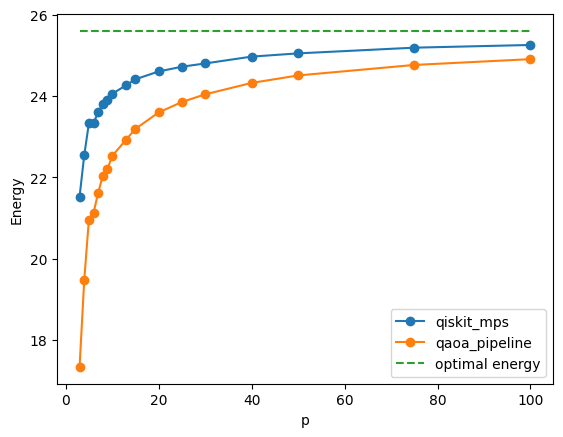

In [40]:
fig, ax  = plt.subplots()
ax.plot(data["ps"], energy_mps_qiskit, marker="o", label="qiskit_mps")
ax.plot(data["ps"], energies, marker="o", label=f"qaoa_pipeline")
ax.plot(data["ps"], [optimal_energy]*len(data["ps"]), label="optimal energy", linestyle="--")
ax.set_xlabel("p")
ax.set_ylabel("Energy")
ax.legend()